In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install import_ipynb
!pip install ogb
!pip install GPUtil

In [ ]:
from GCNConv_feature import GCNConv_feature
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
import numpy as np
import argparse
import torch
import sys
import importlib as ipb
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, ChebConv
import torch.optim.lr_scheduler as lr_scheduler
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import GPUtil
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class Logger(object):
    def __init__(self, runs, info=None):
        self.info = info
        self.results = [[] for _ in range(runs)]
      
    def pickle(self, key_save):
        f = open(key_save, 'wb')
        pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    def unpickle(self, key_save):
        with open(key_save, 'rb') as f:
            return pickle.load(f)

    def add_result(self, run, result):
        assert len(result) == 3
        assert run >= 0 and run < len(self.results)
        self.results[run].append(result)

    def print_statistics(self, run=None):
        if run is not None:
            result = 100 * torch.tensor(self.results[run])
            argmax = result[:, 1].argmax().item()
            print(f'Run {run + 1:02d}:')
            print(f'Highest Train: {result[:, 0].max():.2f}')
            print(f'Highest Valid: {result[:, 1].max():.2f}')
            print(f'Highest Test: {result[:, 2].max():.2f}')
            print(f'  Final Train: {result[argmax, 0]:.2f}')
            print(f'  Final Valid: {result[argmax, 1]:.2f}')
            print(f'   Final Test: {result[argmax, 2]:.2f}')
        else:
            result = 100 * torch.tensor(self.results)

            best_results = []
            for r in result:
                train = r[:, 0].max().item()
                valid = r[:, 1].max().item()
                test = r[:, 2].max().item()
                train2 = r[r[:, 1].argmax(), 0].item()
                test2 = r[r[:, 1].argmax(), 2].item()
                best_results.append((train, valid, test, train2, test2))

            best_result = torch.tensor(best_results)

            print(f'All runs:')
            r = best_result[:, 0]
            print(f'Highest Train: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 1]
            print(f'Highest Valid: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 2]
            print(f'Highest Test: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 3]
            print(f'  Final Train: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 1]
            print(f'  Final Valid: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 4]
            print(f'   Final Test: {r.mean():.2f} ± {r.std():.2f}')


def test(model, data_train, data, split_idx, evaluator):
    model.eval()
    with torch.no_grad():
        train_out=model(data_train.x, data_train.edge_index)
        y_pred_train=train_out.argmax(dim=-1, keepdim=True)
        out = model(data.x, data.adj_t)
        y_pred = out.argmax(dim=-1, keepdim=True)
        train_acc = evaluator.eval({
            'y_true': data_train.y,
            'y_pred': y_pred_train,
        })['acc']
        valid_acc = evaluator.eval({
            'y_true': data.y[split_idx['valid']],
            'y_pred': y_pred[split_idx['valid']],
        })['acc']
        test_acc = evaluator.eval({
            'y_true': data.y[split_idx['test']],
            'y_pred': y_pred[split_idx['test']],
        })['acc']
    return train_acc, valid_acc, test_acc

In [9]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, FC=False):
        super(GNN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.FC = FC
        if self.FC:
            self.convs.append(nn.Linear(in_channels, hidden_channels))
        else:
            self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            if self.FC:
                self.convs.append(nn.Linear(hidden_channels, hidden_channels))
            else:
                self.convs.append(
                    GCNConv(hidden_channels, hidden_channels, cached=True))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        if self.FC:
            self.convs.append(nn.Linear(hidden_channels, out_channels))
        else:
            self.convs.append(GCNConv(hidden_channels, out_channels, cached=True))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            if i > 0:
                x = self.bns[i-1](x)
            if self.FC:
                x = conv(x)
            else:
                x = conv(x, edge_index)
            x = F.relu(x)
            if i == len(self.convs[:-1])-1:
                x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.bns[-1](x)
        if self.FC:
            x = self.convs[-1](x)
        else:
            x = self.convs[-1](x, edge_index)
        return x.log_softmax(dim=-1)


def train(model, data, args):
    model.train()
    # No batch
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out, data.y.squeeze(1))
    loss.backward()
    return loss.item()

In [10]:
class GNN_SVI(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, FC=False):
        super(GNN_SVI, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.FC = FC
        if self.FC:
            self.convs.append(nn.Linear(in_channels, hidden_channels))
        else:
            self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        for _ in range(num_layers - 2):
            if self.FC:
                self.convs.append(nn.Linear(hidden_channels, hidden_channels))
            else:
                self.convs.append(
                    GCNConv(hidden_channels, hidden_channels, cached=True))
        if self.FC:
            self.convs.append(nn.Linear(hidden_channels, out_channels))
        else:
            self.convs.append(
                GCNConv(hidden_channels, out_channels, cached=True))
        self.bns = torch.nn.ModuleList()
        for i in range(num_layers):
            if i == 0:
                continue
            else:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.dropout = dropout
        self.conv_feature = GCNConv_feature(cached=True)
        self.features = [False for i in range(num_layers)]
        self.layers_x = []
        self.append_x = False

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            if i > 0:
                x = self.bns[i-1](x)
            if self.features[i]:
                # Save eta(X_i) for i-th layer weights and biases
                # ALWAYS before x=conv(x,edge_index)
                if self.FC:
                    return x
                else:
                    return self.conv_feature(x, edge_index)
            if self.FC:
                x = conv(x)
            else:
                x = conv(x, edge_index)
            x = F.relu(x)
            if i == len(self.convs[:-1])-1:
                x = F.dropout(x, p=self.dropout, training=self.training)
            if self.append_x:
                x.retain_grad()  # To get the gradient with respect to output
                self.layers_x.append(x)
        x = self.bns[-1](x)
        if self.features[-1]:
            # Save eta(X_i) for i-th layer weights and biases
            # ALWAYS before x=conv(x,edge_index)
            if self.FC:
                return x
            else:
                return self.conv_feature(x, edge_index)
        if self.FC:
            x = self.convs[-1](x)
        else:
            x = self.convs[-1](x, edge_index)
        return x.softmax(dim=-1)


def train_SVI(model, data, args, FC=False, stop_SVI = False):
    # No batch
    model.train()
    # NOTE: lines below are necessary, as o/w model.layers_x grow in size as epoches increases
    model.layers_x = []
    model.append_x = True
    out = model(data.x, data.edge_index)
    model.append_x = False
    loss = F.nll_loss(out, data.y.squeeze(1))
    # loss = F.mse_loss(out.float(), F.one_hot(data.y.squeeze(1)).float())
    loss.backward()
    if stop_SVI == False:
        # Below include SVI. See Algo 1.
        tot_layer = args.num_layers
        for (curr_layer, child) in enumerate(model.convs.children()):
            if curr_layer >= tot_layer:
                continue
            # 2. Get the nonlinear feature at each layer:
            model.features[curr_layer] = True
            feature = model(data.x, data.edge_index).to(device)
            # O/W, the model does not propagates but only returns the features eta(X_i)
            model.features[curr_layer] = False
            n = feature.shape[0]  # Numer of samples
            # For the bias
            feature = torch.cat((feature, torch.ones(n, 1).to(device)),
                                1).to(device)  # n-by-(H+1)
            # 5. Compute gradient and update
            if curr_layer == tot_layer-1:
                output = model(data.x, data.edge_index).to(device)
                Y = F.one_hot(data.y.squeeze(1))
                res = (output - Y).to(device)
            else:
                res = model.layers_x[curr_layer].grad.to(device)
            with torch.no_grad():
                grad = torch.transpose(torch.matmul(torch.transpose(
                    feature, 0, 1), res), 0, 1)
            # print(grad.shape)
            # # This part is for batch normalization
            # if curr_layer < tot_layer-1:
            #     rvar = model.bns[curr_layer].running_var.detach()
            #     weight = model.bns[curr_layer].weight.detach()
            #     grad[:, -1] = grad[:, -1] * (rvar/weight)
            #     grad[:, :-1] = grad[:, :-1] * (rvar/weight)[:, None]
            # Below is specific for GCNConv update.
            i = 0
            for param in child.parameters():
                param.grad.fill_(0)
                if FC:
                    if i == 1:
                        # Bias in second position
                        param.grad += grad[:, -
                                          1].to(device)
                    else:
                        param.grad += grad[:, :-1].to(device)
                else:
                    if i == 0:
                        # Weight in second position
                        param.grad += grad[:, -
                                          1].to(device)
                    else:
                        param.grad += grad[:, :-1].to(device)
                i += 1
    return loss.item()

In [11]:
def slide_idx(data, indices):
    full_mat = data.adj_t.to_scipy().tocsr()
    coo = full_mat[indices][:, indices].tocoo() # This is wrong, because it omits "papers" in the future
    values = coo.data
    sub_indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(sub_indices)
    v = torch.FloatTensor(values)
    shape = coo.shape
    sub_idx = torch.sparse.FloatTensor(i, v, torch.Size(shape)).coalesce().indices()
    sub_x = data.x[indices]
    sub_y = data.y[indices]
    return Data(x=sub_x, y=sub_y, edge_index=sub_idx).to(device)

def mem_report():
    if device.type == 'cuda':
        GPUs = GPUtil.getGPUs()
        for i, gpu in enumerate(GPUs):
            print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(
                i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    else:
        print("CPU RAM Free: "
              + humanize.naturalsize(psutil.virtual_memory().available))

In [ ]:
lr_ls = [0.001]
SVI_ls = [True, False]
optim_ls = ['SGD', 'Adam']
FC = False  # If use fully-connected layers. Default False. NOTE, it can be removed when introducing this as an example publically
change_ratio = False  # If change train, valid, test structure, then set True. Default False. NOTE, it can be removed when introducing this as an example publically
ratio_mult = 0.25 if change_ratio else 1
hidden_channels_ls = [512, 256, 128]
if __name__ == "__main__":
    for lr in lr_ls:
        for use_SVI in SVI_ls:
            for optim_name in optim_ls:
                for hidden_channels in hidden_channels_ls:
                    result_dict = {'SVI-SGD': [], 'SVI-Adam': [], 'SGD': [], 'Adam': []}
                    parser = argparse.ArgumentParser(
                        description='OGBN-Arxiv (GNN)')
                    parser.add_argument('--log_steps', type=int, default=1)
                    parser.add_argument('--num_layers', type=int, default=4)
                    parser.add_argument('--dropout', type=float, default=0.25)
                    parser.add_argument('--lr', type=float, default=lr)
                    parser.add_argument('--momentum', type=float, default=0.95)
                    parser.add_argument('--epochs', type=int, default=500)
                    parser.add_argument('--batch', type=int, default=1)
                    parser.add_argument('--runs', type=int, default=3)
                    parser.add_argument('--SVI', type=bool, default=use_SVI)
                    parser.add_argument(
                        '--optimizer', type=str, default=optim_name)
                    parser.add_argument('-f')
                    args = parser.parse_args()
                    args.FC = FC # If use fully-connected nets instead of GCN layers
                    args.change_ratio = change_ratio # If we change ratio of training and test (only used if "ratio_mult" < 1)
                    args.ratio_mult = ratio_mult  # Only use X% of training data
                    args.lr_drop = 0.98
                    args.dec_epoch = 100
                    if 1e-3 < args.lr and args.lr <= 1e-2:
                        args.lr_drop = 0.96
                    # args.hidden_channels = 512 if args.num_layers >= 3 else 1000
                    args.hidden_channels = hidden_channels
                    print(args)
                    dataset = PygNodePropPredDataset(name='ogbn-arxiv',
                                                    transform=T.ToSparseTensor())
                    data = dataset[0]
                    data.adj_t = data.adj_t.to_symmetric()
                    data = data.to(device)
                    split_idx = dataset.get_idx_split()
                    # Split train to train sub and valid
                    # Always do because we do not want to "peak" into test features
                    train_full = split_idx['train']
                    N = len(train_full)
                    np.random.seed(1103)
                    rand_idx = np.sort(np.random.choice(N, int(N*args.ratio_mult), replace=False))
                    split_idx['train'] = split_idx['train'][rand_idx]
                    data_train=slide_idx(data, split_idx['train'])
                    torch.manual_seed(1103)
                    if args.SVI:
                        model = GNN_SVI(data.num_features, args.hidden_channels,
                                        dataset.num_classes, args.num_layers, args.dropout, args.FC).to(device)
                    else:
                        model = GNN(data.num_features, args.hidden_channels,
                                    dataset.num_classes, args.num_layers,
                                    args.dropout, args.FC).to(device)
                    evaluator = Evaluator(name='ogbn-arxiv')
                    logger = Logger(args.runs, args)
                    results_over_runs = {}
                    for run in range(args.runs):
                        accu_at_run = []
                        model.reset_parameters()
                        if args.optimizer == 'SGD':
                            optimizer = torch.optim.SGD(
                                model.parameters(), lr=args.lr, momentum=args.momentum, nesterov=True)
                        else:
                            optimizer = torch.optim.Adam(
                                model.parameters(), lr=args.lr)
                        for epoch in range(1, 1 + args.epochs):
                            if device.type == 'cuda':
                                # Useful to avoid GPU allocation excess
                                torch.cuda.empty_cache()
                            print(f"LR is {optimizer.param_groups[0]['lr']}")
                            optimizer.zero_grad()
                            if args.SVI:
                                # epoch_stop_SVI = 125 if optim_name == 'SGD' else 50
                                epoch_stop_SVI = 25
                                stop_SVI = False if epoch <= epoch_stop_SVI else True
                                print(f'SVI-{args.optimizer} training')
                                loss = train_SVI(model, data_train, args, args.FC, stop_SVI)
                            else:
                                print(f'{args.optimizer} training')
                                loss = train(model, data_train, args)
                            optimizer.step()
                            mem_report()
                            if epoch > args.dec_epoch:
                                for p in optimizer.param_groups:
                                    p['lr'] *= args.lr_drop
                            print('Testing')
                            result = test(model, data_train, data, split_idx, evaluator)
                            mem_report()
                            logger.add_result(run, result)
                            if epoch % args.log_steps == 0:
                                train_acc, valid_acc, test_acc = result
                                # scheduler.step(valid_acc)
                                accu_at_run += [[train_acc, valid_acc, test_acc]]
                                print(f'Run: {run + 1:02d}, '
                                      f'Epoch: {epoch:02d}, '
                                      f'Loss: {loss:.4f}, '
                                      f'Train: {100 * train_acc:.2f}%, '
                                      f'Valid: {100 * valid_acc:.2f}% '
                                      f'Test: {100 * test_acc:.2f}%')
                        # Running np.array(accu_at_run) would make it into Epoch-by-3 matrices, but doing so causes .json saving error so I just use the list version
                        results_over_runs[f'lr={args.lr}@Run{run+1}'] = accu_at_run
                        logger.print_statistics(run)
                    logger.print_statistics()
                    # Save results
                    key = f'SVI-{optim_name}' if use_SVI else optim_name 
                    fc_use = '-FC' if args.FC else ''
                    c_ratio = '-change_ratio' if args.change_ratio else ''
                    ratio = args.ratio_mult if args.ratio_mult < 1 else ''
                    key_save = f'SVI-{optim_name}-{args.num_layers}layers-{args.hidden_channels}nodes-{args.lr}LR{fc_use}{c_ratio}{ratio}_correct_split' if use_SVI else f'{optim_name}-{args.num_layers}layers-{args.hidden_channels}nodes-{args.lr}LR{fc_use}{c_ratio}{ratio}_correct_split'
                    if use_SVI:
                        key_save += f'_pause_SVI_after{epoch_stop_SVI}'
                    logger.pickle(key_save) # Save it to file, but need not now because only one run.
                    result_dict[key].append(results_over_runs)
                    with open(f"{key_save}.json", "w") as outfile:
                        json.dump(result_dict, outfile)

## Compare the accuracies

In [12]:
def get_mean(result_dict, stop_epoch, return_full=False):
    # Stop_epoch: determine when to stop computing the values.
    full_res = [np.array(i)[:stop_epoch] for i in result_dict.values()]
    if return_full:
        full_mean = np.round(100*np.mean(full_res, axis=0), 2)
        full_std = np.round(100*np.std(full_res, axis=0), 2)
        return [full_mean, full_std]  # For plot
    else:
        idx = [np.argmax(i[:, 1])
               for i in full_res]  # Collect idx at which valid is highest
        vals = [i[j] for i, j in zip(full_res, idx)]
        means = np.round(100*np.mean(vals, axis=0), decimals=2)
        stds = np.round(100*np.std(vals, axis=0), decimals=2)
        return [means, stds]  # For table

In [13]:
def plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC=False, change_ratio=False, ratio_mult=1, full_epoch=True, return_early=False):
        '''
            full_epoch: Decides if we plot the entire trajectory or just the initial segments
        '''
        result_dict = json.load(open(f'{key_SVI}.json'))
        results_over_runs_SVI = result_dict['SVI-SGD'][0]
        result_dict = json.load(open(f'{key_SVI_Adam}.json'))
        results_over_runs_SVI_Adam = result_dict['SVI-Adam'][0]
        result_dict = json.load(open(f'{key_SGD}.json'))
        results_over_runs_SGD = result_dict['SGD'][0]
        result_dict = json.load(open(f'{key_Adam}.json'))
        results_over_runs_Adam = result_dict['Adam'][0]
        stop_epoch = len(results_over_runs_SVI[f'lr={lr0[1:]}@Run1']) if full_epoch else 50
        if return_early:
            results_SVI = get_mean(results_over_runs_SVI, stop_epoch, return_full=False)
            results_SVI_Adam = get_mean(results_over_runs_SVI_Adam, stop_epoch, return_full=False)
            results_SGD = get_mean(results_over_runs_SGD, stop_epoch, return_full=False)
            results_Adam = get_mean(results_over_runs_Adam, stop_epoch, return_full=False)
            # NOTE, they include train test mean and std.
            res_mean = np.concatenate(
                [val[0] for val in [results_SVI, results_SVI_Adam, results_SGD, results_Adam]])
            res_std = np.concatenate(
                [val[1] for val in [results_SVI, results_SVI_Adam, results_SGD, results_Adam]])
            return [res_mean, res_std]
        else:
            results_SVI = get_mean(results_over_runs_SVI, stop_epoch, return_full=True)
            results_SVI_Adam = get_mean(results_over_runs_SVI_Adam, stop_epoch, return_full=True)
            results_SGD = get_mean(results_over_runs_SGD, stop_epoch, return_full=True)
            results_Adam = get_mean(results_over_runs_Adam, stop_epoch, return_full=True)
            res_orig = [results_over_runs_SVI, results_over_runs_SVI_Adam,
                        results_over_runs_SGD, results_over_runs_Adam]
            mpl.rcParams['font.size'] = 20
            mpl.rcParams['axes.titlesize'] = 20
            fig, ax = plt.subplots(1, 4, figsize=(36, 4), sharey=True, sharex=True)
            mtd_dict = {0: 'SVI', 1: 'SVI-Adam', 2: 'SGD', 3: 'Adam'}
            type_dict = {0: 'Train', 1: 'Valid', 2: 'Test'}
            print(f'LR={lr0[1:]} up to {stop_epoch} epochs')
            for i, result in enumerate([results_SVI, results_SVI_Adam, results_SGD, results_Adam]):
                res_mean, res_std = result
                res_mean_final, res_std_final = get_mean(res_orig[i], stop_epoch, return_full=False)
                for j in range(3):  # Train, Valid, Test
                    ax[i].plot(res_mean[:, j], label=type_dict[j])
                    ax[i].fill_between(np.arange(stop_epoch), res_mean[:, j]-res_std[:, j],
                                       res_mean[:, j]+res_std[:, j], alpha=0.3)
                    if j == 0:
                        print(mtd_dict[i])
                    ax[i].set_title(
                        f'{mtd_dict[i]} Final Train {res_mean_final[0]}'+r'$\pm$'+f'{res_std_final[0]}'+f', \n Valid: {res_mean_final[1]}'+r'$\pm$'+f'{res_std_final[1]}'+f', Test: {res_mean_final[2]}'+r'$\pm$'+f'{res_std_final[2]}')
                    ax[i].legend(loc='lower right', ncol=3)
                    ax[i].grid(True)
            fig.tight_layout()
            full_e = '' if full_epoch else '_sub_epoch'
            fc_use = '-FC' if FC else ''
            c_ratio = '-change_ratio' if change_ratio else ''
            ratio = ratio_mult if ratio_mult < 1 else ''
            fig.savefig(f'SVI_SGD_Adam_vs_SGD_Adam{model_architect}{lr0}LR{full_e}{fc_use}{c_ratio}{ratio}_correct_split.pdf',
                        dpi=300, bbox_inches='tight', pad_inches=0)
            plt.show()

### Visualization

512 hidden nodes
LR=0.001 up to 500 epochs
SVI
SVI-Adam
SGD
Adam


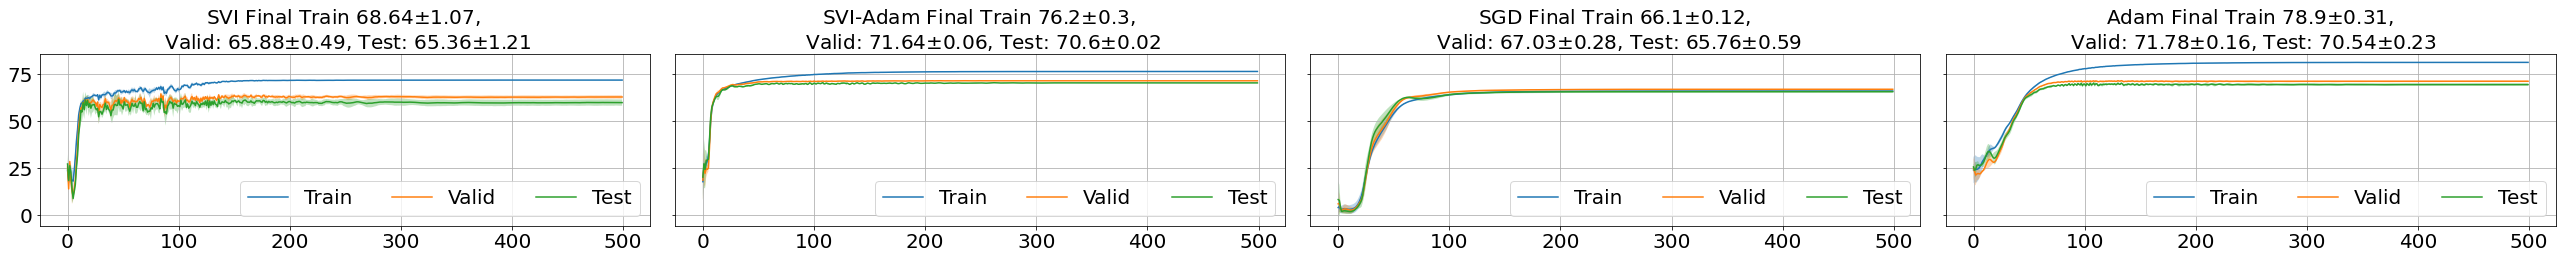

LR=0.001 up to 50 epochs
SVI
SVI-Adam
SGD
Adam


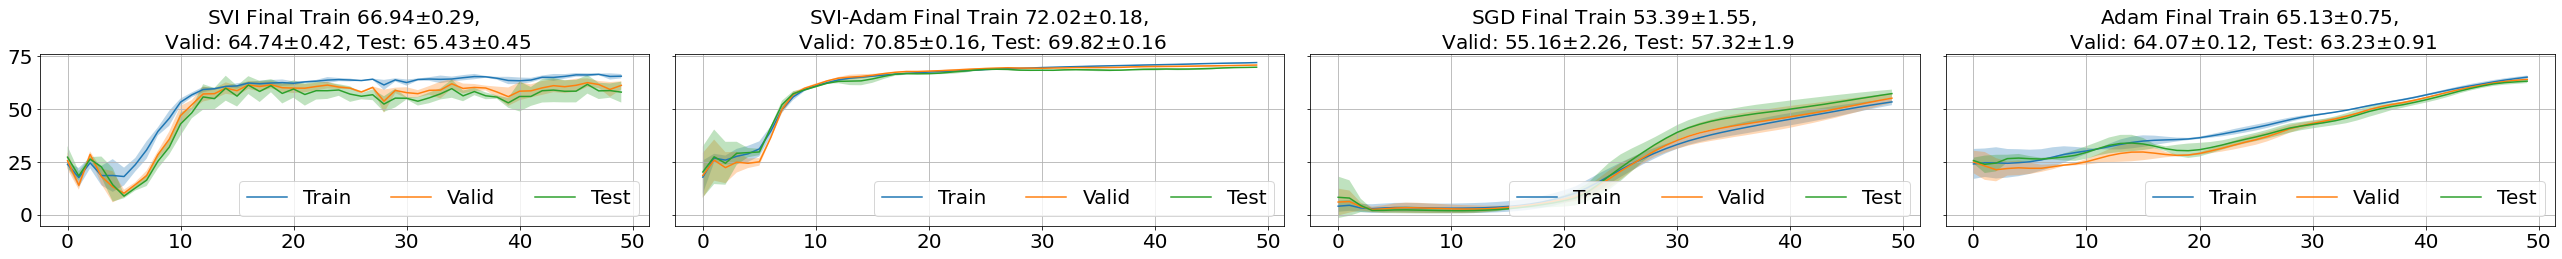

256 hidden nodes
LR=0.001 up to 500 epochs
SVI
SVI-Adam
SGD
Adam


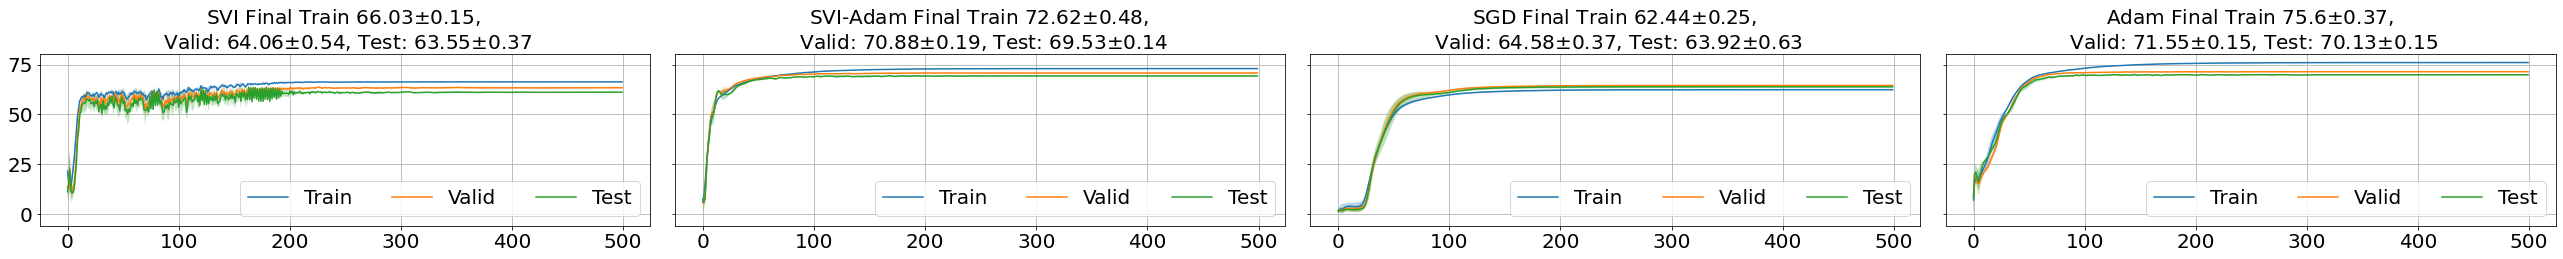

LR=0.001 up to 50 epochs
SVI
SVI-Adam
SGD
Adam


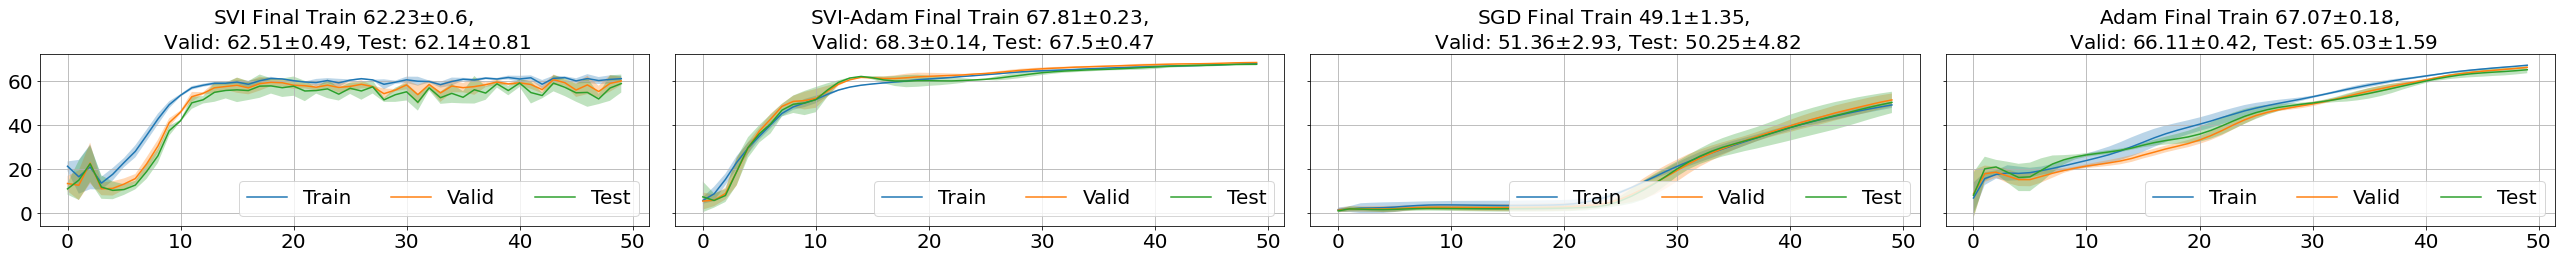

128 hidden nodes
LR=0.001 up to 500 epochs
SVI
SVI-Adam
SGD
Adam


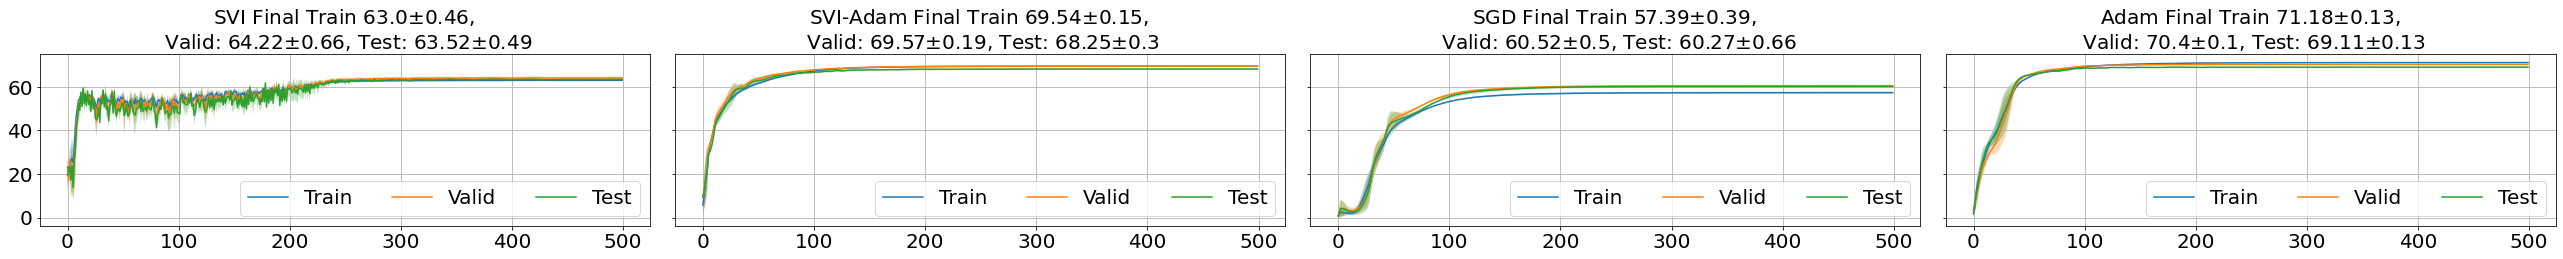

LR=0.001 up to 50 epochs
SVI
SVI-Adam
SGD
Adam


In [14]:
# See appendix for these plots, where I show the number of hidden channels.
lr0 = '-0.001'
hidden_channels_ls = [512, 256, 128]
FC,change_ratio=False,False
fc_use='-FC' if FC else ''
c_ratio='-change_ratio' if change_ratio else ''
for hidden_channels in hidden_channels_ls:
    print(f'{hidden_channels} hidden nodes')
    model_architect=f'-4layers-{hidden_channels}nodes'
    key_SVI = f'SVI-SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    key_SVI_Adam = f'SVI-Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    key_SGD = f'SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio, full_epoch=True)
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio, full_epoch=False)